### 0. Utilities

#### Imports

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from utils.maestri.industry.graphs import (plot_scores_by_role,
                                           plot_scores_by_std)
from utils.maestri.industry.match import classify_maestri_companies
from utils.maestri.industry.stats import get_similarity_summary
from utils.maestri.industry.validation import (
    clear_dissimilar_maestri_industry_matches, validate_maestri_companies)
from utils.maestri.io import export_maestri_to_excel, load_maestri

### 1. Reading the MAESTRI dataset

#### Importing the spreadsheet

In [2]:
maestri_dfs = load_maestri()

In [3]:
maestri_dfs[1].head()

,Company description,NACE code,ISIC code,WZ code,SSIC code
Database ID,,,,,
"5,25,14",Local farms,0150,0150,01500,01412
"8,35,4",Incineration and sanitary landfill,382,382,382,382
"6,21,10",Petroleum exctaction,0610,0610,06100,19201;09001
"6,21,11",Petroleum exctaction,0610,0610,06100,19201;09001
"10,39,5",Sugar refinery,1081,1072,10810,10720


### 2. Obtaining similarity scores for validation

In [4]:
maestri_dfs = validate_maestri_companies(maestri_dfs)

In [5]:
test_dfs = [df.copy() for df in maestri_dfs]

In [6]:
test_dfs = clear_dissimilar_maestri_industry_matches(test_dfs)

In [7]:
test_dfs[1].head()

,Company description,NACE code,ISIC code,ISIC code sim. score,WZ code,WZ code sim. score,SSIC code,SSIC code sim. score
Database ID,,,,,,,,
"5,25,14",Local farms,0150,0150,1.0,01500,1.0,01412,1.0
"8,35,4",Incineration and sanitary landfill,382,382,1.0,382,1.0,382,1.0
"6,21,10",Petroleum exctaction,0610,0610,1.0,06100,1.0,,-1.0
"6,21,11",Petroleum exctaction,0610,0610,1.0,06100,1.0,,-1.0
"10,39,5",Sugar refinery,1081,1072,1.0,10810,1.0,10720,1.0


In [8]:
test_dfs = classify_maestri_companies(test_dfs)

   Providing companies: NACE -> ISIC: 100%|██████████| 305/305 [00:00<00:00, 35809.62it/s]


   Receiving companies: NACE -> SSIC: 100%|██████████| 305/305 [06:36<00:00,  1.30s/it]


In [9]:
test_dfs = validate_maestri_companies(test_dfs)

In [10]:
test_dfs[1].head()

,Company description,NACE code,ISIC code,ISIC code sim. score,WZ code,WZ code sim. score,SSIC code,SSIC code sim. score
Database ID,,,,,,,,
"5,25,14",Local farms,0150,0150,1.0,01500,1.0,01412,1.0
"8,35,4",Incineration and sanitary landfill,382,382,1.0,382,1.0,382,1.0
"6,21,10",Petroleum exctaction,0610,0610,1.0,06100,1.0,09001,0.0
"6,21,11",Petroleum exctaction,0610,0610,1.0,06100,1.0,09001,0.0
"10,39,5",Sugar refinery,1081,1072,1.0,10810,1.0,10720,1.0


### 3. Model performance statistics

#### Summary

In [11]:
get_similarity_summary(test_dfs)

,s = -1,s = 0,0 < s < 1,s = 1
ISIC,0,0,0,668
WZ,0,0,0,668
SSIC,0,131,0,537


In [12]:
get_similarity_summary(test_dfs, is_fraction=True) * 100

,s = -1,s = 0,0 < s < 1,s = 1
ISIC,0.0,0.000000,0.0,100.000000
WZ,0.0,0.000000,0.0,100.000000
SSIC,0.0,19.610778,0.0,80.389222


#### Visualising similarity scores

##### By company role and industry classification standard

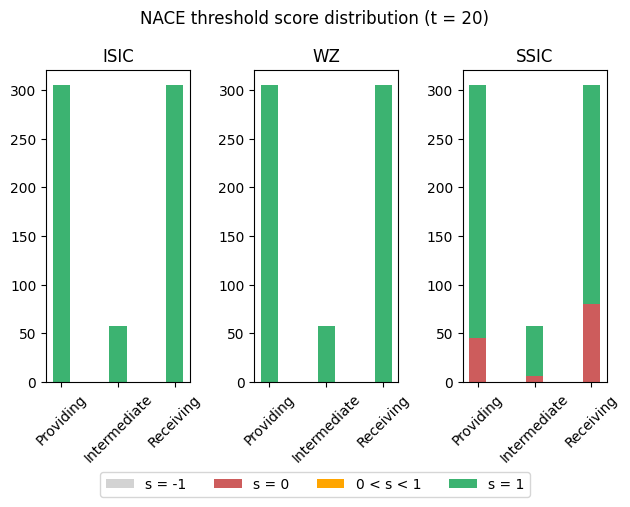

In [13]:
plot_scores_by_role(test_dfs)

##### By industry classification standard

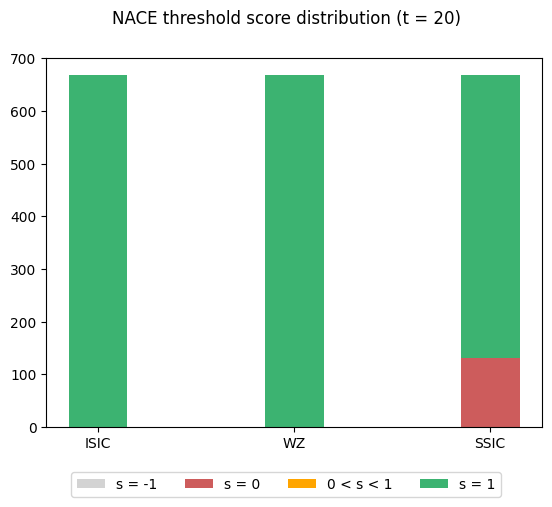

In [14]:
plot_scores_by_std(test_dfs)

### 4. Exporting results to Excel

In [15]:
export_maestri_to_excel(test_dfs, suffix="new")